<a href="https://colab.research.google.com/github/Sarya-Mariam/AI_SpillGuard_OSD-Sarya-Mariam-Jacob/blob/main/Oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from glob import glob
from pathlib import Path


import numpy as np
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split


import albumentations as A

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
DATASET_DIR = '/content/drive/MyDrive/oil_spill_dataset'
IMAGES_DIR = os.path.join(DATASET_DIR, 'train', 'images')
MASKS_DIR = os.path.join(DATASET_DIR, 'masks')


IMG_SIZE = 256
BATCH_SIZE = 8
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
!ls "$DATASET_DIR/train/images" | head -20

Oil (1000).jpg
Oil (1001).jpg
Oil (1002).jpg
Oil (1003).jpg
Oil (1004).jpg
Oil (1005).jpg
Oil (1006).jpg
Oil (1009).jpg
Oil (100).jpg
Oil (1010).jpg
Oil (1011).jpg
Oil (1012).jpg
Oil (1013).jpg
Oil (1015).jpg
Oil (1016).jpg
Oil (1017).jpg
Oil (1018).jpg
Oil (101).jpg
Oil (1020).jpg
Oil (1021).jpg


In [17]:
#  Utility functions
def read_image(path, size=IMG_SIZE):
 img = cv2.imread(path, cv2.IMREAD_COLOR)
 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
 img = img.astype('float32') / 255.0
 return img



def read_mask(path, size=IMG_SIZE):
# Read mask, convert to grayscale, then binary (0/1)
 m = cv2.imread(path, cv2.IMREAD_COLOR)
 if m is None:
  raise FileNotFoundError(path)
# If mask is RGB with colored annotations, convert to grayscale first
 gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
# Threshold to binary: any non-zero pixel -> 1
 binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)
 binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)
 binary = binary.astype('float32')
# Expand dims for channel
 binary = np.expand_dims(binary, axis=-1)
 return binary




def visualize_pipeline(img_path, mask_path, augmentor=None, size=IMG_SIZE):
 img = read_image(img_path, size)
 mask = read_mask(mask_path, size)


# Apply augmentation if provided
 if augmentor is not None:
  augmented = augmentor(image=(img * 255).astype('uint8'), mask=(mask[:,:,0] * 255).astype('uint8'))
  aug_img = augmented['image'].astype('float32') / 255.0
  aug_mask = augmented['mask'].astype('float32') / 255.0
  aug_mask = np.expand_dims((aug_mask > 0.5).astype('float32'), -1)
 else:
  aug_img, aug_mask = None, None


 fig, axs = plt.subplots(1, 4 if augmentor is not None else 3, figsize=(16, 6))
 axs[0].imshow(img)
 axs[0].set_title('Original Image')
 axs[0].axis('off')


 axs[1].imshow(mask[:,:,0], cmap='gray')
 axs[1].set_title('Original Mask (binary)')
 axs[1].axis('off')


 axs[2].imshow(img)
 axs[2].imshow(mask[:,:,0], cmap='jet', alpha=0.4)
 axs[2].set_title('Overlay (preprocessed)')
 axs[2].axis('off')


 if augmentor is not None:
  axs[3].imshow(aug_img)
  axs[3].imshow(aug_mask[:,:,0], cmap='jet', alpha=0.4)
  axs[3].set_title('Augmented Image + Mask')
  axs[3].axis('off')


 plt.tight_layout()
 plt.show()

In [23]:
!find /content/drive/MyDrive/oil_spill_dataset -type f | grep -i mask | head -20


/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1014).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1074).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1008).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1045).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1122).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1093).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1072).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1108).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1084).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1058).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1033).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1128).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1062).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1086).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1100).png
/content/d

To check the files in your masks directory, run the following code. This will list all files and folders within the `MASKS_DIR`.

In [24]:
#  Gather file lists based on dataset split structure
import glob
from pathlib import Path

BASE_DIR = "/content/drive/MyDrive/oil_spill_dataset"  # change if needed

def load_split(split):
    img_dir = os.path.join(BASE_DIR, split, "images")
    mask_dir = os.path.join(BASE_DIR, split, "masks")

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

    if len(image_paths) != len(mask_paths):
        print(f"⚠️ Warning: {split} images={len(image_paths)}, masks={len(mask_paths)} (count mismatch)")

    # Show first few pairs
    for i in range(min(3, len(image_paths))):
        print(f"{split} sample -> Image: {Path(image_paths[i]).name}, Mask: {Path(mask_paths[i]).name}")

    return image_paths, mask_paths

# Load splits
train_imgs, train_masks = load_split("train")
val_imgs, val_masks     = load_split("val")
test_imgs, test_masks   = load_split("test") if os.path.exists(os.path.join(BASE_DIR, "test")) else ([], [])

print("Train:", len(train_imgs), "Val:", len(val_imgs), "Test:", len(test_imgs))


train sample -> Image: Oil (1).jpg, Mask: Oil (1).png
train sample -> Image: Oil (10).jpg, Mask: Oil (10).png
train sample -> Image: Oil (100).jpg, Mask: Oil (100).png
val sample -> Image: Oil (1008).jpg, Mask: Oil (1008).png
val sample -> Image: Oil (1014).jpg, Mask: Oil (1014).png
val sample -> Image: Oil (1033).jpg, Mask: Oil (1033).png
test sample -> Image: Oil (1007).jpg, Mask: Oil (1007).png
test sample -> Image: Oil (1019).jpg, Mask: Oil (1019).png
test sample -> Image: Oil (1024).jpg, Mask: Oil (1024).png
Train: 811 Val: 203 Test: 254


In [26]:
def read_mask(path, size=256):
    # Read mask, convert to grayscale
    m = cv2.imread(path, cv2.IMREAD_COLOR)
    if m is None:
        raise FileNotFoundError(path)
    gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

    # Threshold to binary: any non-zero pixel -> 1
    _, binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)

    # Resize to target size
    binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)

    # Expand dims for channel
    binary = binary.astype('float32')
    binary = np.expand_dims(binary, axis=-1)
    return binary


In [27]:
# Augmentation setup (albumentations)
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
], additional_targets={'mask': 'mask'})

# For validation/test: only resize/normalize
valid_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [30]:
#  tf.data Dataset pipeline

def generator(image_paths, mask_paths, augmentor=None, batch_size=BATCH_SIZE, shuffle=True):
    n = len(image_paths)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idxs = idxs[i:i+batch_size]
            imgs = []
            msks = []
            for j in batch_idxs:
                img = read_image(image_paths[j], IMG_SIZE)
                m = read_mask(mask_paths[j], IMG_SIZE)
                if augmentor is not None:
                    aug = augmentor(image=(img*255).astype('uint8'), mask=(m[:,:,0]*255).astype('uint8'))
                    img = aug['image'].astype('float32') / 255.0
                    mask = aug['mask'].astype('float32') / 255.0
                    # ensure binary mask
                    mask = np.expand_dims((mask > 0.5).astype('float32'), -1)
                else:
                    mask = m
                imgs.append(img)
                msks.append(mask)
            imgs = np.stack(imgs, axis=0)
            msks = np.stack(msks, axis=0)
            yield imgs, msks

# Wrap as tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_imgs, train_masks, augmentor=train_aug, batch_size=BATCH_SIZE, shuffle=True),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(val_imgs, val_masks, augmentor=None, batch_size=BATCH_SIZE, shuffle=False),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

# Prefetching
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [31]:
#  U-Net model definition

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPool2D((2,2))(c)
    return c, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    b = conv_block(p4, 512)

    d4 = decoder_block(b, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d1)

    model = keras.Model(inputs, outputs)
    return model

In [32]:
# Losses and metrics

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return bce + dice_loss

In [33]:
# Compile model
model = build_unet()
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.MeanMetricWrapper(iou_coef, name='iou'),
                       tf.keras.metrics.MeanMetricWrapper(dice_coef, name='dice')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 7,858,433 (29.98 MB)

 Trainable params: 7,852,545 (29.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_oilspill_best.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
]


In [36]:
# Training
EPOCHS = 10
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS,
    callbacks=callbacks
)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7984 - dice: 0.7410 - iou: 0.5896 - loss: 0.8400 - precision: 0.9752 - recall: 0.8030 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2283s 23s/step - accuracy: 0.7992 - dice: 0.7413 - iou: 0.5899 - loss: 0.8391 - precision: 0.9751 - recall: 0.8038 - val_accuracy: 0.9591 - val_dice: 0.7923 - val_iou: 0.6562 - val_loss: 0.6294 - val_precision: 0.9591 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9463 - dice: 0.8222 - iou: 0.6985 - loss: 0.5626 - precision: 0.9733 - recall: 0.9682 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2111s 21s/step - accuracy: 0.9463 - dice: 0.8222 - iou: 0.6986 - loss: 0.5625 - precision: 0.9733 - recall: 0.9682 - val_accuracy: 0.9591 - val_dice: 0.8690 - val_iou: 0.7686 - val_loss: 0.4120 - val_precision: 0.9591 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9468 - dice: 0.8433 - iou: 0.7299 - loss: 0.5406 - precision: 0.9692 - recall: 0.9731 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2100s 21s/step - accuracy: 0.9468 - dice: 0.8433 - iou: 0.7299 - loss: 0.5405 - precision: 0.9692 - recall: 0.9731 - val_accuracy: 0.9605 - val_dice: 0.8749 - val_iou: 0.7779 - val_loss: 0.3952 - val_precision: 0.9621 - val_recall: 0.9982 - learning_rate: 1.0000e-04
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9550 - dice: 0.8575 - iou: 0.7514 - loss: 0.4642 - precision: 0.9718 - recall: 0.9796 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2104s 21s/step - accuracy: 0.9549 - dice: 0.8576 - iou: 0.7514 - loss: 0.4641 - precision: 0.9718 - recall: 0.9797 - val_accuracy: 0.9624 - val_dice: 0.8950 - val_iou: 0.8102 - val_loss: 0.3391 - val_precision: 0.9671 - val_recall: 0.9946 - learning_rate: 1.0000e-04
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2116s 21s/step - accuracy: 0.9545 - dice: 0.8719 - iou: 0.7739 - loss: 0.4228 - precision: 0.9682 - recall: 0.9826 - val_accuracy: 0.9650 - val_dice: 0.8944 - val_iou: 0.8093 - val_loss: 0.3471 - val_precision: 0.9695 - val_recall: 0.9948 - learning_rate: 1.0000e-04
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9588 - dice: 0.8816 - iou: 0.7891 - loss: 0.3876 - precision: 0.9694 - recall: 0.9865 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2121s 21s/step - accuracy: 0.9588 - dice: 0.8816 - iou: 0.7891 - loss: 0.3875 - precision: 0.9694 - recall: 0.9865 - val_accuracy: 0.9658 - val_dice: 0.9159 - val_iou: 0.8451 - val_loss: 0.2837 - val_precision: 0.9690 - val_recall: 0.9962 - learning_rate: 1.0000e-04
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9609 - dice: 0.8964 - iou: 0.8131 - loss: 0.3462 - precision: 0.9701 - recall: 0.9880 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2123s 21s/step - accuracy: 0.9609 - dice: 0.8965 - iou: 0.8132 - loss: 0.3461 - precision: 0.9701 - recall: 0.9880 - val_accuracy: 0.9658 - val_dice: 0.9210 - val_iou: 0.8540 - val_loss: 0.2681 - val_precision: 0.9687 - val_recall: 0.9966 - learning_rate: 1.0000e-04
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9532 - dice: 0.9007 - iou: 0.8204 - loss: 0.3356 - precision: 0.9617 - recall: 0.9882 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2120s 21s/step - accuracy: 0.9533 - dice: 0.9007 - iou: 0.8204 - loss: 0.3355 - precision: 0.9618 - recall: 0.9882 - val_accuracy: 0.9654 - val_dice: 0.9236 - val_iou: 0.8584 - val_loss: 0.2666 - val_precision: 0.9704 - val_recall: 0.9943 - learning_rate: 1.0000e-04
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9581 - dice: 0.9086 - iou: 0.8335 - loss: 0.3190 - precision: 0.9672 - recall: 0.9881 

101/101 ━━━━━━━━━━━━━━━━━━━━ 2122s 21s/step - accuracy: 0.9581 - dice: 0.9086 - iou: 0.8336 - loss: 0.3189 - precision: 0.9672 - recall: 0.9881 - val_accuracy: 0.9656 - val_dice: 0.9333 - val_iou: 0.8753 - val_loss: 0.2336 - val_precision: 0.9698 - val_recall: 0.9951 - learning_rate: 1.0000e-04
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2122s 21s/step - accuracy: 0.9578 - dice: 0.9150 - iou: 0.8443 - loss: 0.2993 - precision: 0.9657 - recall: 0.9894 - val_accuracy: 0.9658 - val_dice: 0.9346 - val_iou: 0.8776 - val_loss: 0.2359 - val_precision: 0.9695 - val_recall: 0.9957 - learning_rate: 1.0000e-04


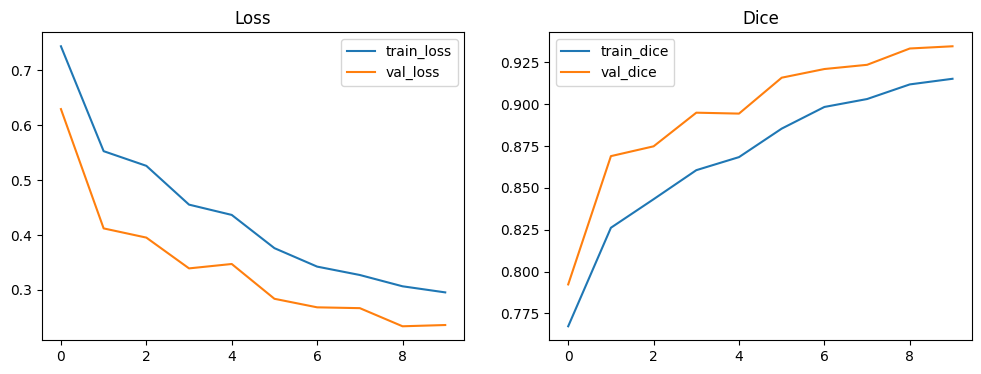

In [37]:
# Training plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice'], label='train_dice')
plt.plot(history.history['val_dice'], label='val_dice')
plt.legend(); plt.title('Dice')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


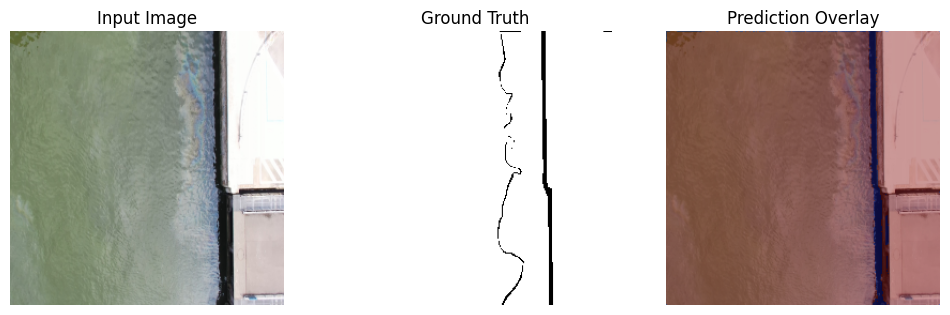

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


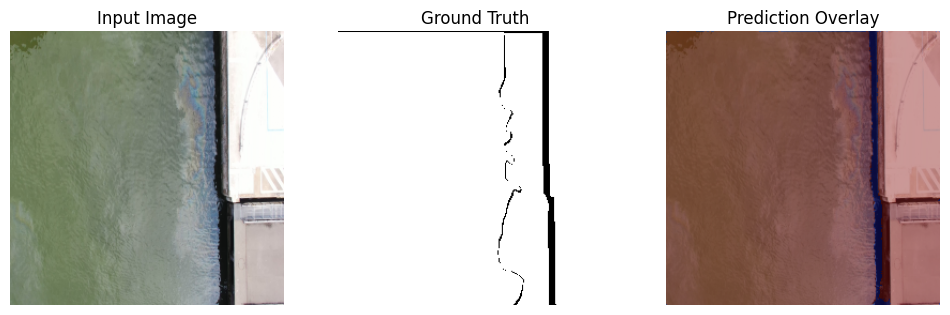

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


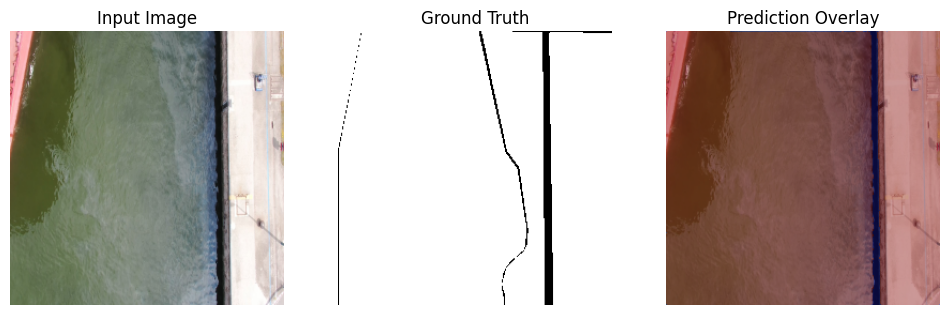

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


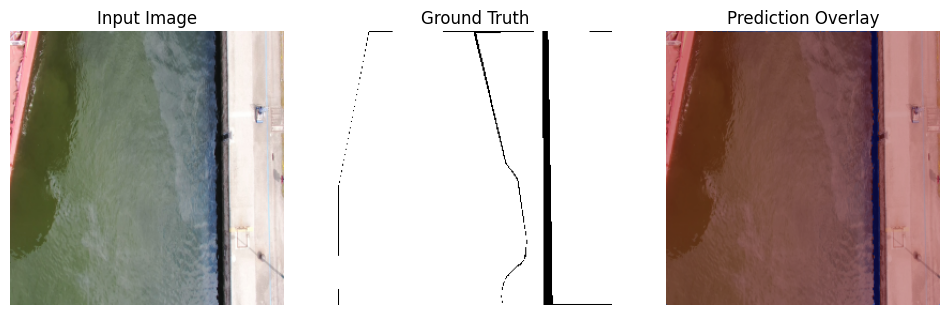

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


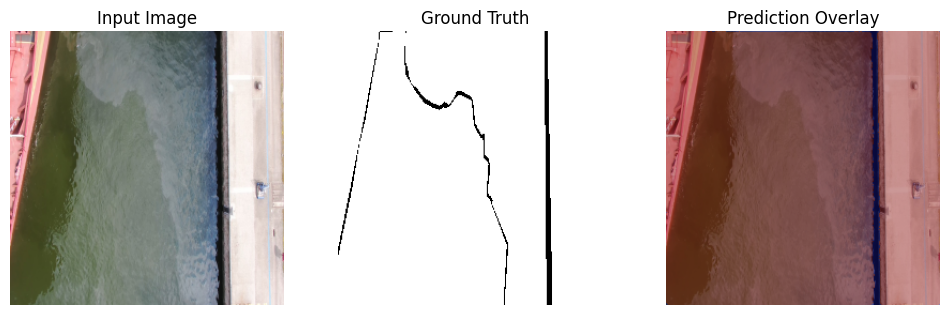

In [38]:
# Visualize predictions on validation set

def predict_and_plot(sample_img_path, sample_mask_path):
    img = read_image(sample_img_path)
    mask = read_mask(sample_mask_path)
    inp = np.expand_dims(img, 0)
    pred = model.predict(inp)[0]
    pred_bin = (pred[:,:,0] > 0.5).astype('float32')

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(img); axs[0].set_title('Input Image'); axs[0].axis('off')
    axs[1].imshow(mask[:,:,0], cmap='gray'); axs[1].set_title('Ground Truth'); axs[1].axis('off')
    axs[2].imshow(img); axs[2].imshow(pred_bin, cmap='jet', alpha=0.4); axs[2].set_title('Prediction Overlay'); axs[2].axis('off')
    plt.show()

# pick a few val samples
for i in range(min(5, len(val_imgs))):
    predict_and_plot(val_imgs[i], val_masks[i])

In [39]:
# Save model and notes
model.save('unet_oilspill_final.h5')
print('Model saved to unet_oilspill_final.h5')


Model saved to unet_oilspill_final.h5
